In [1]:
import pomegranate as pg

## Alarm Example

You’ve set a burglary alarm and moved to the seashore. 

The burglary (event B)  is not so common thing and may happen with probability equal 0.001. Alarm may react to earthquake (E), which may happen with probability 0.002. 

Alarm sounds (A) with 95% if burglary and earthquake happen and with 94% if only burglary happens. It may react to only earthquake with 0.29 probability and may sound without by mistake with probability 0.0001.

Your neighbour, John (J), does never call you (99.9% of the time), but will call you he hears the alarm (he may be out of house with probability of 0.1).

Another neighbour, Mary (M) may call you to talk with probability 0.1 and out of home 30% of her time (but she will hear the alarm and will call you if she is home).

What is the probability Marry will call you if the earthquake happens? 


In [2]:
# define events
burglary = pg.DiscreteDistribution({
    'B': 0.001,
    '-B': 0.999
})

earthquake = pg.DiscreteDistribution({
    'E': 0.002,
    '-E': 0.998
})

alarm = pg.ConditionalProbabilityTable(
    [
        ['B', 'E', 'A', 0.95],
        ['B', 'E', '-A', 0.05],
        
        ['B', '-E', 'A', 0.94],
        ['B', '-E', '-A', 0.06],
        
        ['-B', 'E', 'A', 0.29],
        ['-B', 'E', '-A', 0.71],
        
        ['-B', '-E', 'A', 0.0001],
        ['-B', '-E', '-A', 0.9999],
    ], 
        [burglary, earthquake]
)

John = pg.ConditionalProbabilityTable(
    [
        ['A', 'J', 0.9],
        ['A', '-J', 0.1],
        
        ['-A', 'J', 0.001],
        ['-A', '-J', 0.999],
    ], [alarm]
)

Mary = pg.ConditionalProbabilityTable(
    [
        ['A', 'M', 0.70],
        ['A', '-M', 0.30],
        
        ['-A', 'M', 0.1],
        ['-A', '-M', 0.9],
    ], [alarm]
)

![](download.png)

In [3]:
# define a Bayes Net
b = pg.State(burglary, name="burglary")
e = pg.State(earthquake, name="earthquake")
a = pg.State(alarm, name="alarm")
j = pg.State(John, name="John")
m = pg.State(Mary, name="Mary")

model = pg.BayesianNetwork("Alarm Problem")

# Add the states to the network 
model.add_states(b, e, a, j, m)

# Add the adges
model.add_edge(b, a)
model.add_edge(e, a)

model.add_edge(a, j)
model.add_edge(a, m)

model.bake()

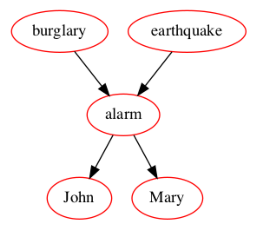

In [4]:
model.plot()

In [5]:
# states(b, e, a, j, m)
model.predict_proba([[None, 'E', None, None, None]])

[array([{
     "class" : "Distribution",
     "dtype" : "str",
     "name" : "DiscreteDistribution",
     "parameters" : [
         {
             "B" : 0.001000000000000443,
             "-B" : 0.9989999999999996
         }
     ],
     "frozen" : false
 },
        'E',
        {
     "class" : "Distribution",
     "dtype" : "str",
     "name" : "DiscreteDistribution",
     "parameters" : [
         {
             "-A" : 0.7093399999999996,
             "A" : 0.29066000000000036
         }
     ],
     "frozen" : false
 },
        {
     "class" : "Distribution",
     "dtype" : "str",
     "name" : "DiscreteDistribution",
     "parameters" : [
         {
             "J" : 0.26230334000000044,
             "-J" : 0.7376966599999997
         }
     ],
     "frozen" : false
 },
        {
     "class" : "Distribution",
     "dtype" : "str",
     "name" : "DiscreteDistribution",
     "parameters" : [
         {
             "-M" : 0.7256039999999997,
             "M" : 0.27439600000000025

Actually, using predefined condition probabilities
we may predict any missed collumn using any number of known values! Also, we may infer conditional probabilities from the dataset

In [6]:
print('\t'.join(model.predict([[None, 'E', None, None, None]])[0]))
print('\t'.join(model.predict([['B', None, None, None, None]])[0]))
print('\t'.join(model.predict([[None, None, None, 'J', 'M']])[0]), ': Looks like burglary is so uncommon, so I must bother only if both calls')
print('\t'.join(model.predict([[None, None, None, None, '-M']])[0]))
print('\t'.join(model.predict([[None, None, None, None, 'M']])[0]))
print('\t'.join(model.predict([[None, None, None, 'J', None]])[0]))

-B	E	-A	-J	-M
B	-E	A	J	M
B	-E	A	J	M : Looks like burglary is so uncommon, so I must bother only if both calls
-B	-E	-A	-J	-M
-B	-E	-A	-J	M
-B	-E	A	J	-M


## Filling blank values
Let's fill blank values into MNIST dataset

In [7]:
# example taken from https://github.com/jmschrei/pomegranate/blob/master/tutorials/B_Model_Tutorial_4_Bayesian_Networks.ipynb

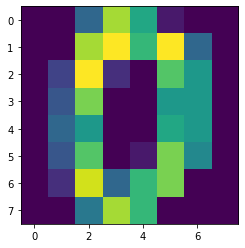

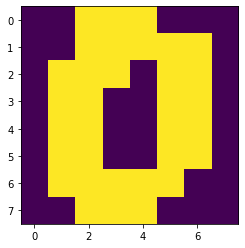

In [8]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np

data = load_digits()
X, _ = data.data, data.target

plt.imshow(X[0].reshape(8, 8))
plt.grid(False)
plt.show()

# Make dataset discrete first
X = (X > np.median(X)).astype('float64')
plt.imshow(X[0].reshape(8, 8))
plt.grid(False)
plt.show()

In [9]:
# hide 10000 pixels from a dataset
np.random.seed(111)

i = np.random.randint(X.shape[0], size=10000)
j = np.random.randint(X.shape[1], size=10000)

X_missing = X.copy()
X_missing[i, j] = np.nan
X_missing

array([[ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0., nan, nan, ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  1.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0., nan,  1., ...,  1.,  0.,  0.],
       [ 0.,  0.,  1., ...,  1.,  0.,  0.]])

In [15]:
# Train a Beayesian Network from samples
# it learns 0's and 1's conditioned on the 0's and 1's of other columns
# we use 2 parents here, since with 1 parent the network is worse than KNN ;)
mdl = pg.BayesianNetwork.from_samples(X_missing, max_parents=2)
y_hat = mdl.predict(X_missing)
np.abs(np.array(y_hat)[i, j] - X[i, j]).mean()

0.1077

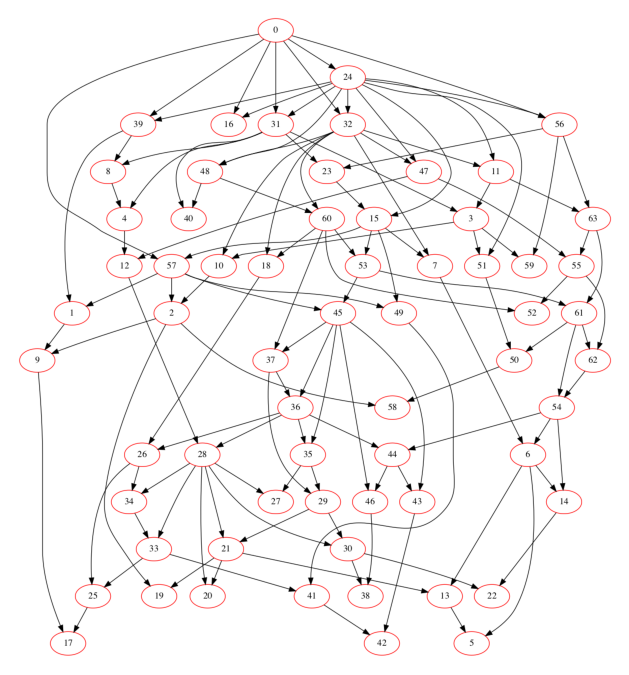

In [23]:
plt.rcParams['figure.dpi'] = 170
mdl.plot()

In [24]:
# what if we used KNN to fill nans
from fancyimpute import KNN

y_pred = KNN(verbose=False).fit_transform(X_missing)[i, j]
np.abs(y_pred - X[i, j]).mean()

0.11092047352895583

The mean abs error is smaller in Bayesian Network!